GROUP RECOMMENDATIONS

Authors: Naa Ashiorkor Nortey and Maureen Wanjiku Githaiga.

Code can be run in any IDE environment with python : Visual Studio Code or Jupiter Notebook.

In [3]:
import pandas as pd
import numpy as np
import math as m
import random as r
from tabulate import tabulate
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import itertools


links = pd.read_csv('ml-latest-small/links.csv')
links.head(5)
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head(5)
tags = pd.read_csv('ml-latest-small/tags.csv')
tags.head(5)
ratings = pd.read_csv("ml-latest-small/ratings.csv")
ratings.head(5)
#dropping the timestamp column
ratings = ratings.drop(['timestamp'], axis=1)
#movie and ratings dataset
movie_ratings = pd.merge(ratings, movies, on='movieId')
movie_ratings.head()
#reshaping the data to table based on column values
user_ptable= ratings.pivot(index='userId', columns='movieId', values='rating')
user_ptable.head()


#pearson correlation coefficient
def pearson_correlation(user_a_ratings,user_b_ratings):
    corr,_ = pearsonr(user_a_ratings,user_b_ratings)
    return corr

def user_collaborative_filtering(target_user,p_table,correlationfunction):
    '''
    Gets the most similar users and their correlations to the target user
    Parameters: int target_user -user id in the dataset
                p_table - data as a pivot table
                correlationfunction - the correlation function to be used
    Return: dict similar_users -dictionary of users who have rated similar movies as the target user
    with their ratings.
    '''
    similar_users = {}
    #other users who are not the target user
    for user_b in p_table.index:
        if user_b != target_user:
            # ratings for the target user and user_b
            target_user_ratings = p_table.loc[target_user].dropna()
            user_b_ratings = p_table.loc[user_b].dropna()

            # common rated movies
            common_rated_movies = target_user_ratings.index.intersection(user_b_ratings.index)
            #filter for at least 2  common rated movies
            if len(common_rated_movies) >= 2:
                #filter  ratings to include only common rated movies
                target_user_ratings = target_user_ratings[common_rated_movies]
                user_b_ratings = user_b_ratings[common_rated_movies]
                #check if either contains all the same elements as correlation will be 1 regardless of actual rating
                if len(set(target_user_ratings)) == 1 or len(set(user_b_ratings)) == 1:
                    continue
                similar_users[user_b] = correlationfunction(target_user_ratings,user_b_ratings)
                    
    return similar_users
     
def user_prediction(user_a,item_p,p_table,similarities):
    '''
    Calculates the predicted rating of user `user_a` for item `item_p`.
    Parameters: int user_a - the index of the target user
                int item_p - the index of the unseen movie by target user
                p_table - pivot table of data
                similarities - the dictionary of correlations between target user
                  and other users.
    Return: int prediction - rating of user a for item p
    '''
    user_a_ratings = p_table.loc[user_a]
    mean_usera_ratings = user_a_ratings.mean()
    unseen_item_ratings = p_table.loc[:, item_p].dropna()

    # Get the similarity scores between the target user and other users who have rated the unseen item.
    #relevant_similarities = {}
    predicted_rating = 0
    weighted_difference = 0
    similarity_sum = 0
    for user_b, similarity in similarities.items():
        if user_b != user_a and user_b in unseen_item_ratings.index:
            user_b_ratings = p_table.loc[user_b]
            mean_userb_ratings = user_b_ratings.mean()
            rating_difference = unseen_item_ratings.loc[user_b] - mean_userb_ratings
            weighted_difference += (similarity*rating_difference)
            similarity_sum += abs(similarity)

    if similarity_sum != 0:
        # the prediction as the active user's mean plus the weighted rating differences
        predicted_rating = mean_usera_ratings + (weighted_difference / similarity_sum)
    else:
        predicted_rating = mean_usera_ratings

    return np.clip(predicted_rating,0.5,5)
   
                                                                                                                                                                          

In [4]:
def get_user_recommendations(user, p_table, correlation_function, prediction_function,top_n = 10):
    '''Function gets the user _recommendations for a particular user using the prediction function
    Returns a dictionary of the movie (key) and the predicted rating(value).
    '''
    similar_users = user_collaborative_filtering(user, p_table, correlation_function)
    sorted_similar_users =  sorted(similar_users.items(), key=lambda item: item[1],reverse=True)
    #sorted_similar_users = sorted(similar_users.items(), key=operator.itemgetter(1), reverse=True)
    top_similar_users = sorted_similar_users[:top_n]
    top_10_similar_users_dict={}
    for user,similarity in top_similar_users:
        top_10_similar_users_dict[user]=similarity
    user_recommendations = {}
    for movie in p_table.columns:
        if pd.isna(p_table.loc[user, movie]):
            user_recommendations[movie] = prediction_function(user, movie, p_table, top_10_similar_users_dict)
    return user_recommendations

In [5]:
def group_recommendations(user_recommendations_dict, aggregation_method, top_n = 10):
    '''Function calculates the group_recommendation based on the given aggregation method.
    The aggregation methods are average and least misery method.
    Returns :list(tuple) of the movies and predicted rating based on selected method'''
  
    movie_ratings = {}
    borda_scores = {}
    #user_recommendations_list = [user_recommendations]
    for user,recommendations in user_recommendations_dict.items():
        for movie, rating in recommendations.items():
            if movie not in movie_ratings:
                movie_ratings[movie] = []
            movie_ratings[movie].append(rating)
    aggregated_ratings = {}   
    if aggregation_method == 'average':
        aggregated_ratings = {movie: np.mean(ratings) for movie, ratings in movie_ratings.items()}

    elif aggregation_method == 'least misery':
        aggregated_ratings = {movie: np.min(ratings) for movie, ratings in movie_ratings.items()}
        
        
    #group recommendations
    sorted_group_recommendations = sorted(aggregated_ratings.items(), key=lambda item: item[1], reverse=True)
    top_group_recommendations = sorted_group_recommendations[:top_n]
    

    return top_group_recommendations


In [6]:
def create_dataframe(data, movies_df):
    '''Creates a data frame...
     Takes a list(tuple) as parameter and a data frame
     Returns: data frame
     '''
    # DataFrame containing movie information
    movie_titles_dict = movies_df.set_index('movieId')['title'].to_dict()

    # Extract movie IDs, ratings, and titles from the list of tuples
    movie_ids, ratings = zip(*data)
    movie_titles = [movie_titles_dict.get(movie_id, 'Unknown') for movie_id in movie_ids]

    movie_df = pd.DataFrame({
        'Movie ID': movie_ids,
        'Title': movie_titles,
        'Rating': ratings
    })

    return movie_df

In [7]:
#group_users = np.random.choice(user_ptable.index, size=3, replace=False)
group_users = [1,2,3]
user_recommendations_dict = {}
for user in group_users:
    user_recommendations_dict [user] = get_user_recommendations(user, user_ptable, pearson_correlation, user_prediction)

average_ratings = group_recommendations(user_recommendations_dict,'average')
least_misery_ratings = group_recommendations(user_recommendations_dict,'least misery')

In [8]:
average_recommendations = create_dataframe(average_ratings,movies)
print(average_recommendations)

   Movie ID                                              Title    Rating
0      1674                                     Witness (1985)  4.845372
1        47                        Seven (a.k.a. Se7en) (1995)  4.787860
2      1198  Raiders of the Lost Ark (Indiana Jones and the...  4.758586
3      3863                                   Cell, The (2000)  4.686715
4      2028                         Saving Private Ryan (1998)  4.684813
5       750  Dr. Strangelove or: How I Learned to Stop Worr...  4.575039
6      1129                        Escape from New York (1981)  4.575039
7      3740                 Big Trouble in Little China (1986)  4.575039
8       101                               Bottle Rocket (1996)  4.568435
9       968                    Night of the Living Dead (1968)  4.568435


In [9]:
least_misery_recommendations = create_dataframe(least_misery_ratings,movies)
print(least_misery_recommendations)

   Movie ID                                              Title    Rating
0      1674                                     Witness (1985)  4.690743
1      2028                         Saving Private Ryan (1998)  4.408040
2        47                        Seven (a.k.a. Se7en) (1995)  4.363581
3     58559                            Dark Knight, The (2008)  4.356047
4      3863                                   Cell, The (2000)  4.306452
5      1198  Raiders of the Lost Ark (Indiana Jones and the...  4.275758
6      2959                                  Fight Club (1999)  4.111072
7      2571                                 Matrix, The (1999)  4.106466
8      8368    Harry Potter and the Prisoner of Azkaban (2004)  4.058494
9      4993  Lord of the Rings: The Fellowship of the Ring,...  4.033421


#part b measuring disagreements

The way for counting disagreements between users in a group using cosine similarity. 

The proposed method for taking disagreements into account is considering the disagreements between users by using cosine similarity and incorporating these disagreements as weights when aggregating individual recommendations into group recommendations.
Calculation of Disagreements:
Users' recommendations are organized into a matrix where each row represents a user, and each column corresponds to an item or movie.
Cosine similarity is computed between the transpose of this matrix, comparing the recommendations of each user with every other user.
Subtracting the cosine similarity values from 1 yields a dissimilarity measure, indicating the degree of disagreement between users.

Creation of Disagreement DataFrame:
The dissimilarity values are structured into a DataFrame (disagreements_df), where each entry (i, j) denotes the disagreement between user i and user j.

Normalization of Disagreements to Create Weights:
Disagreement values are normalized to a scale where higher values signify stronger disagreement and lower values denote stronger agreement.
This normalization process aims to standardize the dissimilarity metrics, preparing them to be used as weights in subsequent calculations.

Weighted Aggregation for Group Recommendations:
Each user's recommendations are multiplied by their corresponding normalized weight based on disagreements.
The weighted recommendations from all users are then aggregated to form group recommendations.
This approach ensures that users with greater agreement contribute more to the final group recommendations, while users with more significant differences have a diminished impact.

Normalization of Aggregated Recommendations:
The aggregated recommendations are normalized to a predefined rating range (0 to 5), ensuring consistency and interpretability.

In summary, cosine similarity provides a measure of dissimilarity between users' recommendations, enabling the system to account for differences in preferences. The dissimilarity values are then normalized to create weights, and these weights are used to adjust the influence of each user's recommendations when generating group recommendations. This methodology enhances the group recommendation process by taking into consideration the varying degrees of agreement and disagreement among users in the group.

The proposed method is useful when producing group recommendations because:

Mitigating Individual Differences: By incorporating disagreements through cosine similarity, the method gives less weight to users who have significantly different preferences, mitigating the influence of outliers.

Balancing Group Preferences: The weighted aggregation ensures that users with more similar preferences contribute more to the group recommendations, leading to a balanced and consensus-driven set of suggestions.

Customizing Recommendations: Taking disagreements into account allows the system to tailor recommendations to better suit the collective preferences of the group, providing suggestions that are more likely to be acceptable to a majority of users.

Reducing Individual Bias: The method helps reduce the impact of individual biases or extreme preferences, promoting a more collaborative and inclusive approach to group recommendations.

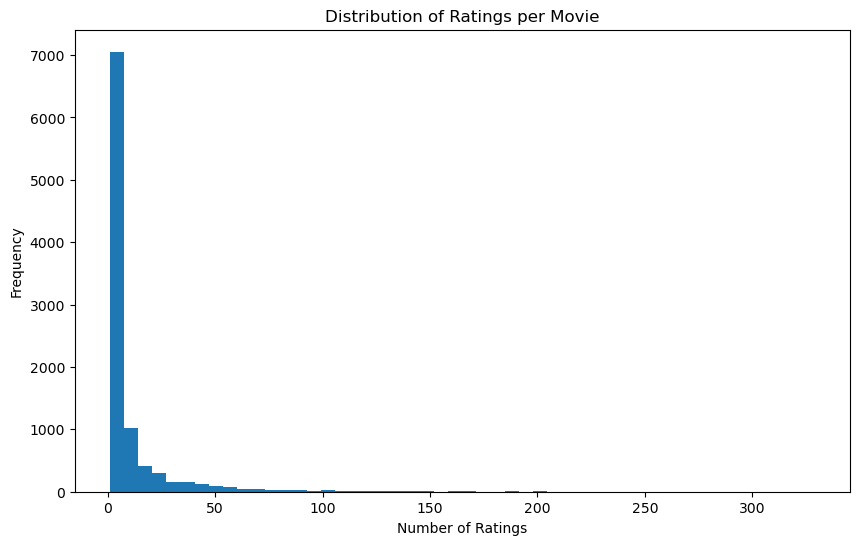

In [10]:
# Group by 'movieId' and count the number of ratings for each movie
movie_ratings_count = ratings.groupby('movieId').size()

# Plotting the distribution of ratings per movie
plt.figure(figsize=(10, 6))
plt.hist(movie_ratings_count, bins=50)
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings per Movie')
plt.show()


In [23]:
#user recommendations dict as a DataFrame
recommendations_df = pd.DataFrame(user_recommendations_dict)
# commonly recommended items to the 3 users
common_recommendations = recommendations_df.dropna(axis=0, how='any')
#recommendations for each of the 3 users using the user based approach 
#common_recommendations.columns = ['User 1', 'User 2', 'User 3']

#common_recommendations.index.name = 'Movie_ID'
print(common_recommendations)


               1         2         3
2       3.951613  4.638581  2.790394
3       3.951613  3.953163  2.790394
4       3.951613  3.798077  3.186047
5       3.951613  3.798077  3.186047
6       3.951613  3.365724  3.729486
...          ...       ...       ...
193581  3.951613  3.798077  3.186047
193583  3.951613  3.798077  3.186047
193585  3.951613  3.798077  3.186047
193587  3.951613  3.798077  3.186047
193609  3.951613  3.798077  3.186047

[9600 rows x 3 columns]


In [12]:
#Calculating disaggreements
disagreements = 1 - cosine_similarity(common_recommendations.T)
# Create a DataFrame with disagreements
disagreements_df = pd.DataFrame(disagreements, columns=common_recommendations.columns, index=common_recommendations.columns)

print(disagreements_df)

              User 1        User 2        User 3
User 1 -1.283418e-13  4.360430e-03  6.465788e-03
User 2  4.360430e-03  5.084821e-14  6.981026e-03
User 3  6.465788e-03  6.981026e-03  3.042011e-14


In [13]:
# Normalize disagreements to create weights
#by subtracting from 1 we 
weights = 1 - (disagreements_df - disagreements_df.min()) / (disagreements_df.max() - disagreements_df.min())
weights


,User 1,User 2,User 3
User 1,1.000000,0.375388,0.073806
User 2,0.325615,1.000000,0.000000
User 3,0.000000,0.000000,1.000000


In [14]:
# Weighted Aggregation for group recommendations
weighted_aggregated_recommendations = common_recommendations.copy()

# multiplying each user's recommendation by their corresponding weight based on disagreements
for user in common_recommendations.columns:
    weighted_aggregated_recommendations[user] *= weights.loc[user, user]

# Sum up the weighted recommendations across users to get aggregated recommendations
group_recommendations = weighted_aggregated_recommendations.sum(axis=1)

In [15]:
#group_recommendations_avg = weighted_aggregated_recommendations.sum(axis=1) / 3


In [16]:
# normalized aggregated recommendations to range (0 and 5)
min_rating = 0 
max_rating = 5  

normalized_group_recommendations = (
    (group_recommendations - group_recommendations.min()) / (group_recommendations.max() - group_recommendations.min())
) * (max_rating - min_rating) + min_rating

print(normalized_group_recommendations)

Movie_ID
2         3.635807
3         3.322349
4         3.432365
5         3.432365
6         3.483168
            ...   
193581    3.432365
193583    3.432365
193585    3.432365
193587    3.432365
193609    3.432365
Length: 9600, dtype: float64


In [17]:
type(normalized_group_recommendations)

pandas.core.series.Series

In [28]:
def weighted_group_recommendation(common_recommendations):
    '''
    parameters : dataframe of  common user recommendations
    returns the group recommendations ->pd series
    
    '''
    #Calculating disaggreements
    disagreements = 1 - cosine_similarity(common_recommendations.T)
    # Create a DataFrame with disagreements
    disagreements_df = pd.DataFrame(disagreements, columns=common_recommendations.columns, index=common_recommendations.columns)
    weights = 1 - (disagreements_df - disagreements_df.min()) / (disagreements_df.max() - disagreements_df.min())
    # Weighted Aggregation for group recommendations
    weighted_aggregated_recommendations = common_recommendations.copy()

    # multiplying each user's recommendation by their corresponding weight based on disagreements
    for user in common_recommendations.columns:
        weighted_aggregated_recommendations[user] *= weights.loc[user, user]

    # Sum up the weighted recommendations across users to get aggregated recommendations
    group_recommendations = weighted_aggregated_recommendations.sum(axis=1)
    # normalized aggregated recommendations to range (0 and 5)
    min_rating = 0 
    max_rating = 5  

    normalized_group_recommendations = (
        (group_recommendations - group_recommendations.min()) / (group_recommendations.max() - group_recommendations.min())
    ) * (max_rating - min_rating) + min_rating

    return normalized_group_recommendations


In [27]:
d = weighted_group_recommendation(common_recommendations)
top_10 = d.sort_values(ascending=False).head(10)
type(top_10)

pandas.core.series.Series

In [19]:
# pd series to tuples
list_of_tuples = list(zip(normalized_group_recommendations.index, normalized_group_recommendations.values))
sorted_recommendations = sorted(list_of_tuples, key=lambda x: x[1], reverse=True)

#top 10 recommendations for the group using weighted aggregation method
top_10_recommendations = sorted_recommendations[:10]
weighted_group_recommendations = create_dataframe(top_10_recommendations,movies)
weighted_group_recommendations



,Movie ID,Title,Rating
0,47,Seven (a.k.a. Se7en) (1995),5.000000
1,1198,Raiders of the Lost Ark (Indiana Jones and the...,4.959837
2,3863,"Cell, The (2000)",4.861231
3,750,Dr. Strangelove or: How I Learned to Stop Worr...,4.708015
4,1129,Escape from New York (1981),4.708015
5,3740,Big Trouble in Little China (1986),4.708015
6,101,Bottle Rocket (1996),4.698955
7,968,Night of the Living Dead (1968),4.698955
8,1235,Harold and Maude (1971),4.698955
9,1285,Heathers (1989),4.698955


In [20]:
# movie in top 10 recommendations
top_movies = [movie for movie, _ in top_10_recommendations]

# ratings for the top 10 recommended movies from the common recommended movies
ratings_for_top_movies = common_recommendations[common_recommendations.index.isin(top_movies)].rename(columns={1: 'User 1', 2: 'User 2',3: 'User 3'})
ratings_for_top_movies

print(ratings_for_top_movies)

            User 1  User 2    User 3
Movie_ID                            
47        5.000000     5.0  4.363581
101       3.951613     5.0  4.753694
750       3.951613     5.0  4.773504
968       3.951613     5.0  4.753694
1129      3.951613     5.0  4.773504
1198      5.000000     5.0  4.275758
1235      3.951613     5.0  4.753694
1285      3.951613     5.0  4.753694
3740      3.951613     5.0  4.773504
3863      4.306452     5.0  4.753694


In [21]:
weighted_group_recommendations.set_index ('Movie ID', inplace=True)
#Concatenated df
concatenated_df = weighted_group_recommendations.join(ratings_for_top_movies)
concatenated_df

,Title,Rating,User 1,User 2,User 3
Movie ID,,,,,
47,Seven (a.k.a. Se7en) (1995),5.000000,5.000000,5.0,4.363581
1198,Raiders of the Lost Ark (Indiana Jones and the...,4.959837,5.000000,5.0,4.275758
3863,"Cell, The (2000)",4.861231,4.306452,5.0,4.753694
750,Dr. Strangelove or: How I Learned to Stop Worr...,4.708015,3.951613,5.0,4.773504
1129,Escape from New York (1981),4.708015,3.951613,5.0,4.773504
3740,Big Trouble in Little China (1986),4.708015,3.951613,5.0,4.773504
101,Bottle Rocket (1996),4.698955,3.951613,5.0,4.753694
968,Night of the Living Dead (1968),4.698955,3.951613,5.0,4.753694
1235,Harold and Maude (1971),4.698955,3.951613,5.0,4.753694
